# component-based TPA: pseudo-forces

In this example a numerical example is used to demonstrate a pseudo-forces TPA.

In [2]:
import pyFBS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
%matplotlib inline

## Example datasets

Load the required predefined datasets:

In [3]:
pyFBS.download_lab_testbench()

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 4651.48it/s]

In [4]:
xlsx_pos = r"./lab_testbench/Measurements/TPA_synt.xlsx"

stl_A = r"./lab_testbench/STL/A.stl"
stl_B = r"./lab_testbench/STL/B.stl"
stl_AB = r"./lab_testbench/STL/AB.stl"

df_acc_AB = pd.read_excel(xlsx_pos, sheet_name='Sensors_AB')
df_chn_AB = pd.read_excel(xlsx_pos, sheet_name='Channels_AB')
df_imp_AB = pd.read_excel(xlsx_pos, sheet_name='Impacts_AB')
df_pf_AB = pd.read_excel(xlsx_pos, sheet_name='PseudoForces_A')

df_acc_A = pd.read_excel(xlsx_pos, sheet_name='Sensors_A')
df_imp_A = pd.read_excel(xlsx_pos, sheet_name='Impacts_A')
df_chn_A = pd.read_excel(xlsx_pos, sheet_name='Channels_A')

df_vp = pd.read_excel(xlsx_pos, sheet_name='VP_Channels')
df_vpref = pd.read_excel(xlsx_pos, sheet_name='VP_RefChannels')

## Numerical model

Load the corresponding .full and .ress file from the example datasets:

In [5]:
full_file_AB = r"./lab_testbench/FEM/AB.full"
ress_file_AB = r"./lab_testbench/FEM/AB.rst"

full_file_A = r"./lab_testbench/FEM/A.full"
ress_file_A = r"./lab_testbench/FEM/A.rst"

 Create an MK model for each component:

In [6]:
MK_AB = pyFBS.MK_model(ress_file_AB, full_file_AB, no_modes=100, recalculate=False)
MK_A = pyFBS.MK_model(ress_file_A, full_file_A, no_modes=100, recalculate=False)

C:\Users\tomaz.bregar\Anaconda3\lib\site-packages\pyvista\core\pointset.py:610: UserWarning: VTK 9 no longer accepts an offset array
  warnings.warn('VTK 9 no longer accepts an offset array')


The locations and directions of responses and excitations often do not match exactly with the numerical model, so we need to find the nodes closest to these points. Only the locations are updated, the directions remain the same.

In [7]:
df_chn_AB_up = MK_AB.update_locations_df(df_chn_AB)
df_imp_AB_up = MK_AB.update_locations_df(df_imp_AB)
df_pf_AB_up = MK_AB.update_locations_df(df_pf_AB)

df_chn_A_up = MK_A.update_locations_df(df_chn_A)
df_imp_A_up = MK_A.update_locations_df(df_imp_A)

## 3D view

Open 3D viewer in the background. With the 3D viewer the subplot capabilities of PyVista can be used.

In [8]:
view3D = pyFBS.view3D(show_origin=False, show_axes=False, title="TPA")

Add the STL file of structure AB to the plot and show the corresponding accelerometer, channels and impacts.

In [9]:
view3D.plot.add_text("AB", position='upper_left', font_size=10, color="k", font="times", name="AB_structure")

view3D.add_stl(stl_AB, name="AB_structure", color="#8FB1CC", opacity=.1)
view3D.plot.add_mesh(MK_AB.mesh, scalars=np.zeros(MK_AB.mesh.points.shape[0]), show_scalar_bar=False, name="mesh_AB", cmap="coolwarm", show_edges=True)
view3D.show_chn(df_chn_AB_up, color="green", overwrite=True)
view3D.show_imp(df_imp_AB_up, color="red", overwrite=True);
view3D.show_acc(df_acc_AB, overwrite=True)
view3D.show_vp(df_vp, color="blue", overwrite=True)

view3D.label_imp(df_imp_AB_up)
view3D.label_acc(df_acc_AB)

## FRF sythetization

 Perform the FRF sythetization for each component based on the updated locations. First, structural admittance $\boldsymbol{\text{Y}}_{4\text{ps}}^{\text{AB}}$ is obtained.

In [10]:
MK_AB.FRF_synth(df_chn_AB_up, df_pf_AB_up, f_start=0, modal_damping=0.003, frf_type="accelerance")
Y4ps_AB = MK_AB.FRF[:,:9,:]
Y4ps_AB.shape

(2000, 9, 6)

Then, structural admittance $\boldsymbol{\text{Y}}_{3\text{ps}}^{\text{AB}}$ is obtained.

In [11]:
Y3ps_AB = MK_AB.FRF[:,9:12,:]
Y3ps_AB.shape

(2000, 3, 6)

Define operational displacements $\boldsymbol{\text{u}}_4$:

In [12]:
MK_AB.FRF_synth(df_chn_AB_up, df_imp_AB_up, f_start=0, modal_damping=0.003, frf_type="accelerance")

imp_loc = 10

u4 = MK_AB.FRF[:, :9, imp_loc:imp_loc+1]
u4.shape

(2000, 9, 1)

## Virtual point transformation

The VPT can be performed directly on the generated data. First, structural admittance in interface DoF ($\boldsymbol{\text{Y}}_{22}^{\text{A}}$) is obtained:

In [13]:
MK_A.FRF_synth(df_chn_A_up, df_imp_A_up, f_start=0, modal_damping=0.003, frf_type="accelerance")

In [14]:
vpt_A = pyFBS.VPT(df_chn_A_up[:9], df_imp_A_up[:9], df_vp, df_vpref)

Apply the defined VP transformation on the FRFs:

In [15]:
vpt_A.apply_VPT(MK_A.freq, MK_A.FRF[:,:9,:9])

In [16]:
Y22_A = vpt_A.vptData
Y22_A.shape

(2000, 6, 6)

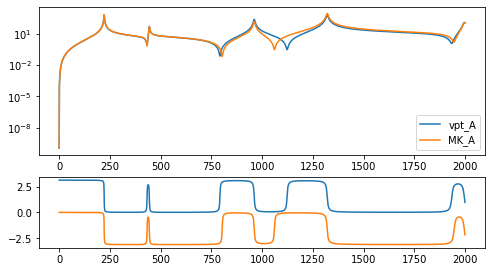

In [17]:
select_out = 2
select_in = 2

plt.figure(figsize=(8,6))
plt.subplot(211)
plt.semilogy(np.abs(vpt_A.vptData[:,select_out,select_in]), label='vpt_A')
plt.semilogy(np.abs(MK_A.FRF[:,select_out,select_in]), label='MK_A')
plt.legend(loc=0)

plt.subplot(413)
plt.plot(vpt_A.freq, np.angle(vpt_A.vptData[:,select_out,select_in]))
plt.plot(vpt_A.freq, np.angle(MK_A.FRF[:,select_out,select_in]));

In second step, $\boldsymbol{\text{Y}}_{2\text{ps}}^{\text{A}}$ is calculated:

In [18]:
MK_A.FRF_synth(df_chn_A_up, df_pf_AB_up, f_start=0, modal_damping=0.003, frf_type="accelerance")

Apply the defined VP transformation on the FRFs:

In [19]:
Y2ps_A = vpt_A.Tu@MK_A.FRF[:,:9,:]
Y2ps_A.shape

(2000, 6, 6)

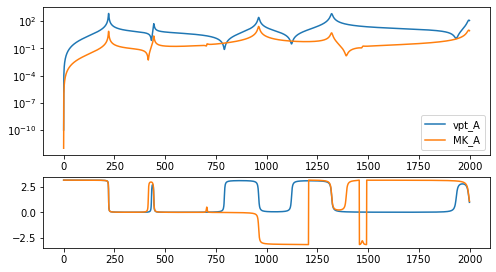

In [20]:
select_out = 2
select_in = 2

plt.figure(figsize=(8,6))
plt.subplot(211)
plt.semilogy(np.abs(vpt_A.vptData[:,select_out,select_in]), label='vpt_A')
plt.semilogy(np.abs(MK_A.FRF[:,select_out,select_in]), label='MK_A')
plt.legend(loc=0)

plt.subplot(413)
plt.plot(vpt_A.freq, np.angle(vpt_A.vptData[:,select_out,select_in]))
plt.plot(vpt_A.freq, np.angle(MK_A.FRF[:,select_out,select_in]));

In [21]:
vpt_AB = pyFBS.VPT(df_chn_AB_up[:9], df_imp_AB_up[:9], df_vp, df_vpref)

In [22]:
Y32_AB = MK_AB.FRF[:, 9:12, :9]@vpt_AB.Tf
Y32_AB.shape

(2000, 3, 6)

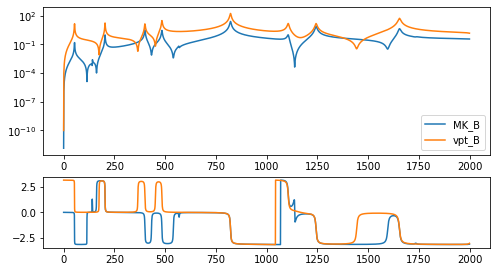

In [23]:
select_out = 2
select_in = 2

plt.figure(figsize = (8,6))
plt.subplot(211)
plt.semilogy(MK_AB.freq, np.abs(MK_AB.FRF[:,9+select_out,select_in]), label='MK_B')
plt.semilogy(MK_AB.freq, np.abs(Y32_AB[:,select_out,select_in]), label='vpt_B')
plt.legend(loc=0)

plt.subplot(413)
plt.plot(MK_AB.freq, np.angle(MK_AB.FRF[:,9+select_out,select_in]))
plt.plot(MK_AB.freq, np.angle(Y32_AB[:,select_out,select_in]));

## Pseudo-forces

Calculation of pseudo-forces:

In [24]:
f_ps = np.linalg.pinv(Y4ps_AB)@u4
f_ps.shape

(2000, 6, 1)

Calcualting response $\boldsymbol{\text{u}}_3^{\text{TPA}}$.

In [25]:
u3 = Y3ps_AB @ f_ps
u3.shape

(2000, 3, 1)

On board validation: comparison of predicted $\boldsymbol{\text{u}}_{3}^{\text{TPA}}$ and operational $\boldsymbol{\text{u}}_{3}^{\text{MK}}$:

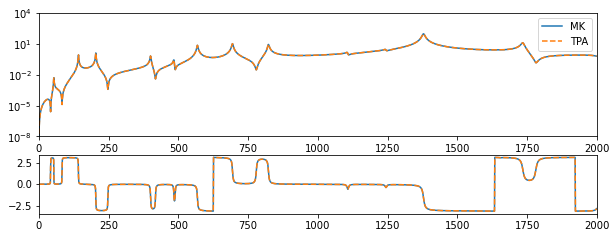

In [26]:
plt.figure(figsize=(10, 5))

u3_MK = MK_AB.FRF[:, 9:12, imp_loc:imp_loc+1]
sel = 0

plt.subplot(211)
plt.semilogy(np.abs(u3_MK[:,sel,0]), label='MK');
plt.semilogy(np.abs(u3[:,sel,0]), '--', label='TPA');
plt.ylim(10**-8, 10**4);
plt.xlim(0, 2000)
plt.legend(loc=0);

plt.subplot(413)
plt.plot(np.angle(u3_MK[:,sel,0]));
plt.plot(np.angle(u3[:,sel,0]), '--');
plt.xlim(0, 2000);

## Equivalent interface forces

Calculation of equivalent interface forces from pseudo-forces:

In [27]:
f2_eq = np.linalg.pinv(np.linalg.pinv(Y2ps_A) @ Y22_A) @ f_ps

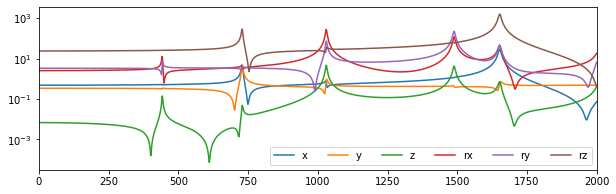

In [28]:
lab = ['x', 'y', 'z', 'rx', 'ry', 'rz']
plt.figure(figsize = (10,3))
for i in range(f2_eq.shape[1]):
    plt.semilogy(np.abs(f2_eq[:, i, 0]), label=lab[i]);
plt.legend(loc=0, ncol=len(lab));
plt.xlim(0,2000);

## Path contributions

Path contributions from equivalent forces:

In [29]:
sel = 0

u_partial = np.zeros_like(f2_eq)

for j in range(f2_eq.shape[1]):
    u_partial[:,j:j+1,0:1] = Y32_AB[:,sel:sel+1,j:j+1]@f2_eq[:,j:j+1,:]

In [30]:
u_partial.shape

(2000, 6, 1)

Contributing paths can be examined using a following display:

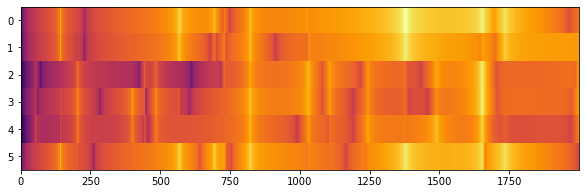

In [31]:
plt.figure(figsize=(10, 3))
values = np.abs(np.reshape(u_partial, (2000, 6))).T[:, 1:]
plt.imshow(values, aspect='auto', cmap=cm.inferno, interpolation='nearest', norm=LogNorm(vmin=np.min(values), vmax=np.max(values)));

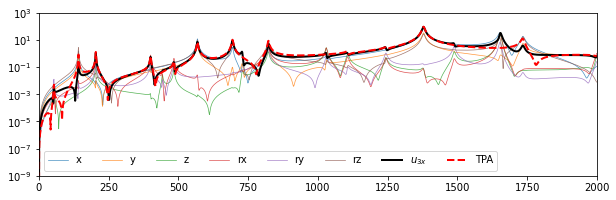

In [32]:
lab = ['x', 'y', 'z', 'rx', 'ry', 'rz']
plt.figure(figsize = (10,3))
for i in range(u_partial.shape[1]):
    plt.semilogy(np.abs(u_partial[:, i, 0]), label=lab[i], lw=0.7, alpha=0.8);
plt.semilogy(np.abs(np.sum(u_partial, axis=1)), 'k', lw=2, label=r'$u_{3x}$')
plt.semilogy(np.abs(u3[:,sel]), '--', color='red', lw=2, label='TPA')
plt.legend(loc=0, ncol=len(lab)+2);
plt.xlim(0, 2000);
plt.ylim(10**-9, 10**3);